## ETL PROCESS REPORT
--------------------------------------------
### Source Data:

[data.gov](https://catalog.data.gov/dataset/crime-data-from-2010-to-present)

[yelp developers](https://www.yelp.com/developers/documentation/v3)

--------------------------------------------

### E: PULLING additional DATA from  YELP'S API and data.gov(census):

* Step 1: Get an API KEY  from yelp
* Investigate what kind of data to retrieve. In our case: General business profiles in the City of LA California
* The API returns only 50 results max per call
* Perform a test pull to look at the result and it's json structure to design the data frame

### T: PREPROCESSING THE JSON RESPONSE FROM THE API's:
--------------------------------------------

* Declare/Initialize the variables/columns that will hold the downloaded data
* We build a dataset of 1000 resutls by making multiple calls dynamically and saving data into a dataframe on the fly
* Data processing consisted in extracting data from the json response and formatting it to create tabular data for the df
* The Transforming process included string manipulation regex and python scripting.

### L: LOADING TO SQL AND MONGODB:
--------------------------------------------
* This was the most straightforward step accomplished with no issues
* We simplify this proces by using sqlite instead of mysql or postgress
* We also saved csv files of the data before we loaded it into the database systems.


In [2]:
import pandas as pd
import numpy as np
import re

import diffs_latlong
from diffs_latlong import computeNearestZip
import time
import matplotlib.pyplot as plt
csv_file = "Resources/Crime_Data_from_2010_to_Present.csv"


### Dataset for this Notebook:
[LA CRIME SOURCE DATA](https://catalog.data.gov/dataset/crime-data-from-2010-to-present)


In [3]:
crime_df = pd.read_csv(csv_file)

In [7]:
crime_df.tail(2)

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
1967974,191005089,01/26/2019,01/01/2010,1000,10,West Valley,1029,354,THEFT OF IDENTITY,1822 0377,...,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,7000 WOODLEY AV,NaN,"(34.1976, -118.4837)"
1967975,191505220,01/24/2019,01/05/2010,700,15,N Hollywood,1555,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",1202 0701,...,NaN,IC,Invest Cont,341.0,NaN,NaN,NaN,5000 LANKERSHIM BL,NaN,"(34.1611, -118.3723)"


In [8]:
# The 'Location ' column has a blank space at the end
crime_df.columns

Index(['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred',
       'Area ID', 'Area Name', 'Reporting District', 'Crime Code',
       'Crime Code Description', 'MO Codes', 'Victim Age', 'Victim Sex',
       'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location '],
      dtype='object')

In [9]:
crime_df = crime_df.rename(columns={"Location ": "location"})

In [11]:
# Inspect the new location column
crime_df.columns[-1]

'location'

In [12]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967976 entries, 0 to 1967975
Data columns (total 26 columns):
DR Number                 int64
Date Reported             object
Date Occurred             object
Time Occurred             int64
Area ID                   int64
Area Name                 object
Reporting District        int64
Crime Code                int64
Crime Code Description    object
MO Codes                  object
Victim Age                int64
Victim Sex                object
Victim Descent            object
Premise Code              float64
Premise Description       object
Weapon Used Code          float64
Weapon Description        object
Status Code               object
Status Description        object
Crime Code 1              float64
Crime Code 2              float64
Crime Code 3              float64
Crime Code 4              float64
Address                   object
Cross Street              object
location                  object
dtypes: float64(6), int64(6),

In [13]:
# Regex to extract lat and long out of the location column
# and make 2 new columns from the values.
crime_df[['lat', 'long']] = crime_df['location'].replace\
    (to_replace=["\)","\("], value="", regex=True).str.split(",", expand = True)

In [14]:
crime_df.head(2)

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,location,lat,long
0,11401303,09/13/2010,09/12/2010,45,14,Pacific,1485,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,...,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,"(33.9599, -118.3962)",33.9599,-118.3962
1,70309629,08/09/2010,08/09/2010,1515,13,Newton,1324,946,OTHER MISCELLANEOUS CRIME,0344,...,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,"(34.0224, -118.2524)",34.0224,-118.2524


In [15]:
# Convert lat and longs to numeric values: 
# Needed for the computeNearestZip function(Extract zip from lat long)
crime_df['lat'] = pd.to_numeric(crime_df['lat'])
crime_df['long'] = pd.to_numeric(crime_df['long'])

In [16]:
type(crime_df['lat'][0]), type(crime_df['long'][0])

(numpy.float64, numpy.float64)

### Examining the structure of the dataframe

In [17]:
len(crime_df.columns)

28

In [18]:
crime_df.shape

(1967976, 28)

In [19]:
# 15 columns that have no missing values at all
crime_df.dropna(axis=1).shape

(1967976, 15)

In [22]:
# only 19 rows out of 1967976 are without missing values
crime_df.dropna(axis=0).shape

(19, 28)

In [24]:
print(f"Total entries in age column: {crime_df['Victim Age'].count()}")
print(f"Total entries with age == 0: {crime_df[crime_df['Victim Age']==0]['Victim Age'].count()}")
print(f"Rows with age == 0:{round(float(crime_df[crime_df['Victim Age']==0]['Victim Age'].count()/crime_df['Victim Age'].count()*100),2)} %")


Total entries in age column: 1967976
Total entries with age == 0: 358005
Rows with age == 0: 18.19 %


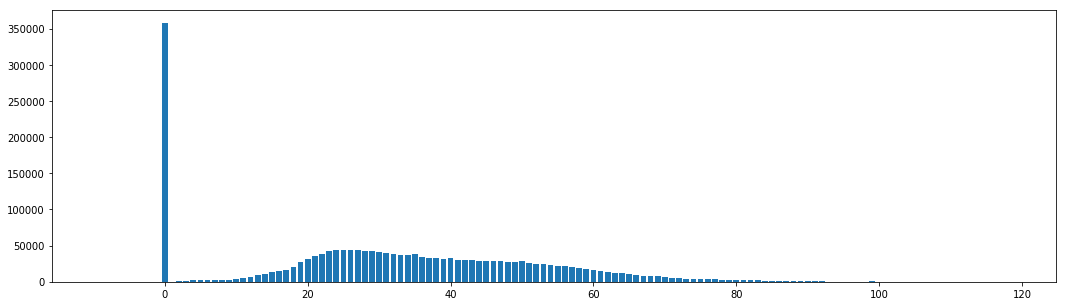

In [34]:
# Quick visual inspection of the 'Victim Age' column for the above reasons ☝🏾
data = crime_df['Victim Age'].value_counts()
names = list(data.index)
fig, axs = plt.subplots(figsize=(18, 5))
axs.bar(names, data)

plt.show()

In [36]:
# Ages with negative numbers exactly 9 😰
# it probalby refers to an unborn victim (pregnancy stage of victim's mother)?
crime_df[crime_df['Victim Age'] < 0].groupby('Victim Age')['Victim Age'].count()


Victim Age
-9      2
-8      1
-7      4
-6     10
-5     17
-4     23
-3     51
-2    102
-1    221
Name: Victim Age, dtype: int64

In [59]:
# The huge amount of zeros in dataset coud be that in data entry process the person 
# preparing the report could not leave the field blank: This could reflect unknown ages
# of victims perhaps because incomplete or unfinished reports that victims abandon or 
# Unknown ages of these victims? 
 #No missing values in this column
crime_df['Victim Age'].isnull().values.any(), crime_df['Victim Age'].isnull().values.sum()


(False, 0)

In [200]:
print(f"Total columns in dataset: {len(crime_df.columns)}")
print(f"Number of Columns with no missing values: {len(crime_df.dropna(axis=1).columns)}")

Total columns in dataset: 28
Number of Columns with no missing values: 15


In [199]:
print(f" Only {len(crime_df.dropna(axis=0))}\
 Rows with no missing values out of {len(crime_df)} total Rows")


 Only 19 Rows with no missing values out of 1967976 total Rows


# Mapping lat long to a zip code with helper funcion imported from diffs_latlong.py

In [51]:
# Wrapper function needed to execute the computeNearestZip script. It wont work otherwise
def zipWrapper(myDf):
    lat = myDf['lat']
    long = myDf['long']
    return computeNearestZip(lat, long)


In [202]:
# Testing computeNearestZip: it maps a pair of lat/long to its zip code
zipTester = computeNearestZip(33.8677, -84.4645)
zipTester, type(zipTester)


('30339', str)

In [94]:
# Our computeNearestZip algorithm is heavy on computer resources.
# It would probably take several weeks to run on 1.9 million rows
# Created a smaller df to test its functionality
latlong1k_df = crime_df[['lat','long']][:1000]
latlong1k_df.tail(2)


,lat,long
998,34.0376,-118.2594
999,34.0516,-118.2561


In [95]:
# Function to test the time it takes for our computeNearestzip function to run
def timer():
    begining = time.time()
    latlong1k_df['zip'] = latlong1k_df.apply(func=zipWrapper, axis=1)
    end = time.time()
    total = end-begining
    print(f"It took {total} seconds to process {len(latlong1k_df['zip'])} Rows")
          

In [96]:
timer()

It took 69.20011687278748 seconds to process 1000 Rows


In [103]:
# Create a slice of the original dataframe to use in the project
_1k_crime_df = crime_df[:1000].copy()
_1k_crime_df.tail(2)


,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,location,lat,long
998,100112825,06/22/2010,06/21/2010,1600,1,Central,185,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0104 0344 0601,...,Invest Cont,341.0,NaN,NaN,NaN,100 E 12TH ST,NaN,"(34.0376, -118.2594)",34.0376,-118.2594
999,100112827,06/22/2010,06/22/2010,745,1,Central,152,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0344,...,Invest Cont,341.0,NaN,NaN,NaN,500 S FLOWER ST,NaN,"(34.0516, -118.2561)",34.0516,-118.2561


In [104]:
# Create the zip column by  applying the computeNearestzip function to it
_1k_crime_df['zip'] = _1k_crime_df.apply(func=zipWrapper, axis=1)


In [106]:
# Inspect the new zip column
_1k_crime_df.iloc[-2:, -4:]

,location,lat,long,zip
998,"(34.0376, -118.2594)",34.0376,-118.2594,90015
999,"(34.0516, -118.2561)",34.0516,-118.2561,90071


# Load  (Mongo and SQL)

In [115]:
# Save the _1k_crime_df to a csv file
#added the amount of rows to the name of the file for easy finding
_1k_crime_df.to_csv(f"Resources/crime{_1k_crime_df['zip'].count()}.csv", index=False)


# mongodb

In [116]:
import pymongo

In [117]:
# Setup connection to mongodb
conn = "mongodb://localhost:27017"
client = pymongo.MongoClient(conn)

# Select database and collection to use
db = client.moe_la_crime
crime_reports = db.crime_reports

In [120]:
# Convert the dataframe to dictionary format for mongo
crimeData = _1k_crime_df.to_dict(orient='records')

In [121]:
# inspect the dictionary 
crimeData[0]

{'DR Number': 11401303,
 'Date Reported': '09/13/2010',
 'Date Occurred': '09/12/2010',
 'Time Occurred': 45,
 'Area ID': 14,
 'Area Name': 'Pacific',
 'Reporting District': 1485,
 'Crime Code': 740,
 'Crime Code Description': 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
 'MO Codes': '0329',
 'Victim Age': 0,
 'Victim Sex': 'M',
 'Victim Descent': 'W',
 'Premise Code': 101.0,
 'Premise Description': 'STREET',
 'Weapon Used Code': nan,
 'Weapon Description': nan,
 'Status Code': 'IC',
 'Status Description': 'Invest Cont',
 'Crime Code 1': 740.0,
 'Crime Code 2': nan,
 'Crime Code 3': nan,
 'Crime Code 4': nan,
 'Address': 'SEPULVEDA                    BL',
 'Cross Street': 'MANCHESTER                   AV',
 'location': '(33.9599, -118.3962)',
 'lat': 33.9599,
 'long': -118.3962,
 'zip': '90045'}

In [122]:
crime_reports.insert_many(crimeData)

In [128]:
# Test query the mongo db
results = crime_reports.find()
for result in results[:2]:
    print(result, '\n')

{'_id': ObjectId('5ce41f22be1a77b335fc0108'), 'DR Number': 11401303, 'Date Reported': '09/13/2010', 'Date Occurred': '09/12/2010', 'Time Occurred': 45, 'Area ID': 14, 'Area Name': 'Pacific', 'Reporting District': 1485, 'Crime Code': 740, 'Crime Code Description': 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)', 'MO Codes': '0329', 'Victim Age': 0, 'Victim Sex': 'M', 'Victim Descent': 'W', 'Premise Code': 101.0, 'Premise Description': 'STREET', 'Weapon Used Code': nan, 'Weapon Description': nan, 'Status Code': 'IC', 'Status Description': 'Invest Cont', 'Crime Code 1': 740.0, 'Crime Code 2': nan, 'Crime Code 3': nan, 'Crime Code 4': nan, 'Address': 'SEPULVEDA                    BL', 'Cross Street': 'MANCHESTER                   AV', 'location': '(33.9599, -118.3962)', 'lat': 33.9599, 'long': -118.3962, 'zip': '90045'} 

{'_id': ObjectId('5ce41f22be1a77b335fc0109'), 'DR Number': 70309629, 'Date Reported': '08/09/2010', 'Date Occurred': '08/09/2010', 'Time Occurred': 1515, 'Area 

## Create a second collection (census zips):

In [133]:
# Read in from census zips csv file
census_df = pd.read_csv('Resources/censusZips2017.csv')
census_df[:2]

,Zipcode,Population,Unemployment Count,Unemployment Rate
0,601,17599.0,2454.0,13.943974
1,602,39209.0,2538.0,6.473004


In [134]:
# Save df to dictionary for mongo uploading
censusData = census_df.to_dict(orient = 'records')

In [135]:
### Create the  collection to hold census data
censusZips = db.censusZips

In [136]:
censusZips.insert_many(censusData)

In [137]:
## Test query the mongodb new collection
censusResults = censusZips.find()

In [138]:
for result in censusResults[:2]:
    print(result, '\n')

{'_id': ObjectId('5ce42261be1a77b335fc04f0'), 'Zipcode': 601, 'Population': 17599.0, 'Unemployment Count': 2454.0, 'Unemployment Rate': 13.943974089436901} 

{'_id': ObjectId('5ce42261be1a77b335fc04f1'), 'Zipcode': 602, 'Population': 39209.0, 'Unemployment Count': 2538.0, 'Unemployment Rate': 6.473003647121835} 



#  SQL

In [140]:
from sqlalchemy import create_engine

In [141]:
database_path = "Resources/moe_crime.sqlite"

In [142]:
engine = create_engine(f"sqlite:///{database_path}")

In [143]:
engine.table_names()

[]

In [144]:
_1k_crime_df.to_sql(name='LaCrime', con=engine, if_exists='append', index=False)


In [145]:
engine.table_names()

['LaCrime']

In [163]:
# Test Query the LaCrime table
pd.read_sql_query('select * from LaCrime', con=engine).tail()


,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,location,lat,long,zip
995,100112811,06/22/2010,06/20/2010,100,1,Central,171,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0344 1251,...,341.0,NaN,NaN,None,900 S FIGUEROA ST,None,"(34.0462, -118.2628)",34.0462,-118.2628,90017
996,100112818,06/22/2010,05/05/2010,1330,1,Central,119,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0344,...,341.0,NaN,NaN,None,800 N ALAMEDA ST,None,"(34.0563, -118.2374)",34.0563,-118.2374,90012
997,100112821,06/22/2010,06/17/2010,1630,1,Central,192,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329 0601,...,740.0,NaN,NaN,None,1300 S FLOWER ST,None,"(34.0401, -118.2668)",34.0401,-118.2668,90015
998,100112825,06/22/2010,06/21/2010,1600,1,Central,185,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0104 0344 0601,...,341.0,NaN,NaN,None,100 E 12TH ST,None,"(34.0376, -118.2594)",34.0376,-118.2594,90015
999,100112827,06/22/2010,06/22/2010,745,1,Central,152,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0344,...,341.0,NaN,NaN,None,500 S FLOWER ST,None,"(34.0516, -118.2561)",34.0516,-118.2561,90071


## Create a second Table (census zips):

In [154]:
# Import data for the census table
censusData = pd.read_csv('Resources/censusZips2017.csv')


In [160]:
censusData[:2]


,Zipcode,Population,Unemployment Count,Unemployment Rate
0,601,17599.0,2454.0,13.943974
1,602,39209.0,2538.0,6.473004


In [157]:
# check tables
engine.table_names()


['LaCrime']

In [158]:
# Create the new CensusZips table 
censusData.to_sql(name='CensusZips', con=engine, if_exists='append', index=False)


In [164]:
engine.table_names()


['CensusZips', 'LaCrime']

### Test Query the CensusZips table

In [165]:
pd.read_sql_query('select * from CensusZips', con=engine).tail()


,Zipcode,Population,Unemployment Count,Unemployment Rate
33115,99923,0.0,0.0,NaN
33116,99925,901.0,124.0,13.762486
33117,99926,1684.0,132.0,7.838480
33118,99927,59.0,0.0,0.000000
33119,99929,2455.0,83.0,3.380855


# Test Query both tables  performing a join on the zip code

In [211]:
query1 = '''
SELECT `Crime Code Description` as crime,
`Unemployment Rate` FROM LaCrime
JOIN CensusZips on CensusZips.Zipcode = LaCrime.zip
GROUP by crime ORDER by `Unemployment Rate` DESC
'''
query2 = '''
SELECT `Crime Code Description` as crime,  CensusZips.Zipcode as census_zip, 
LaCrime.zip as la_zip, `Unemployment Rate` FROM LaCrime
JOIN CensusZips on census_zip = la_zip
GROUP by `crime`
ORDER by `Unemployment Rate` DESC ;
'''


In [212]:
pd.read_sql_query(query1, con=engine)[:15]


,crime,Unemployment Rate
0,ARSON,6.832818
1,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,6.832818
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",6.832818
3,BATTERY WITH SEXUAL CONTACT,6.832818
4,BRANDISH WEAPON,6.832818
5,COUNTERFEIT,6.832818
6,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,6.832818
7,INTIMATE PARTNER - AGGRAVATED ASSAULT,6.832818
8,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",6.832818
9,"RAPE, FORCIBLE",6.832818


In [213]:
pd.read_sql_query(query2, con=engine)[:15]


,crime,census_zip,la_zip,Unemployment Rate
0,ARSON,90013,90013,6.832818
1,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,90013,90013,6.832818
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",90013,90013,6.832818
3,BATTERY WITH SEXUAL CONTACT,90013,90013,6.832818
4,BRANDISH WEAPON,90013,90013,6.832818
5,COUNTERFEIT,90013,90013,6.832818
6,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,90013,90013,6.832818
7,INTIMATE PARTNER - AGGRAVATED ASSAULT,90013,90013,6.832818
8,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",90013,90013,6.832818
9,"RAPE, FORCIBLE",90013,90013,6.832818


## TESTING LINES 👇🏾

#### FALIED TEST TO THE ZIP EXTRACTION FUNCTION @ BOTTOM

In [194]:
crime_df[crime_df.columns[1]].value_counts().count()

3420

In [195]:
crime_df['Date Reported'].count()/crime_df['Date Reported'].value_counts().count()

575.4315789473684

In [196]:
crime_df['Victim Descent'].value_counts()

H    670251
W    472918
B    309864
O    187504
X     64807
A     46805
K      8504
F      2280
I       846
C       824
J       322
P       320
U       174
V       139
Z        92
G        77
S        30
D        20
L        14
-         3
Name: Victim Descent, dtype: int64

In [197]:
crime_df['Victim Descent'].unique()

array(['W', 'H', 'O', 'B', 'A', 'X', nan, 'K', 'V', 'J', 'F', 'P', 'C',
       'I', 'U', 'D', 'G', 'Z', 'L', 'S', '-'], dtype=object)

In [113]:
# 😾
small_df = crime_df[:10]
small_df

small_df['zip'] = small_df.apply(computeNearestZip(small_df['lat'],small_df['long']), axis=1)


TypeError: cannot convert the series to <class 'float'>